<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230612_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data drift에 내성이 있는 학습 방법

In [27]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [29]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [30]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [31]:

def test_model(model_,model2_, tX, ty, s1):
    model_.eval()

    if model2_ == None:
        ax = tX[:,0:5]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [32]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output


In [33]:

def test_all_data(generator,adapter,XT,yT):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            if adapter == None:
                xs = tmp_x[:,0:5]
            else:
                xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [34]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(2, 50))
            self.fc2.append(nn.Linear(50, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)
            
        return torch.cat(pxy, dim=1)
     

In [35]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):
    seed_everything()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        else:
            xs = XS_train[:,0:5]
            a_loss = 0

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss
            
        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )
            
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

# 준비
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

In [36]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [37]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

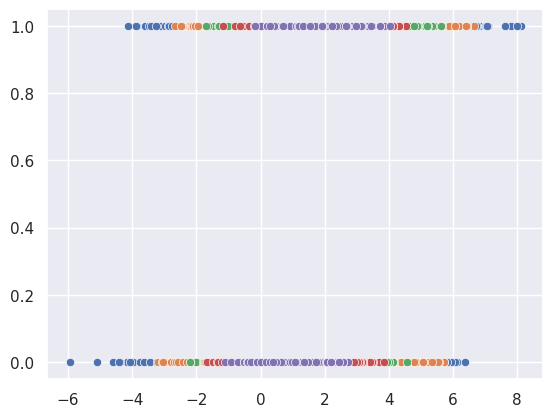

In [38]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

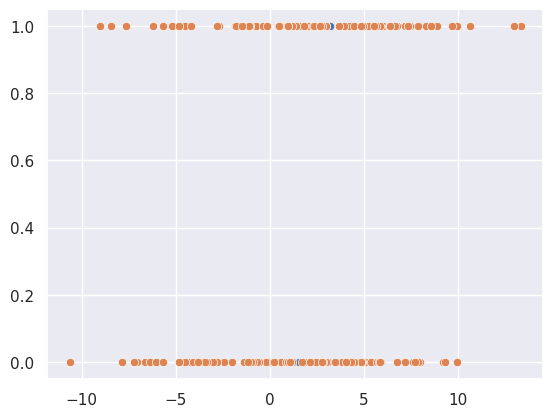

In [39]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## KS-test 통계량의 측정

In [40]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [41]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [42]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 70.63it/s]


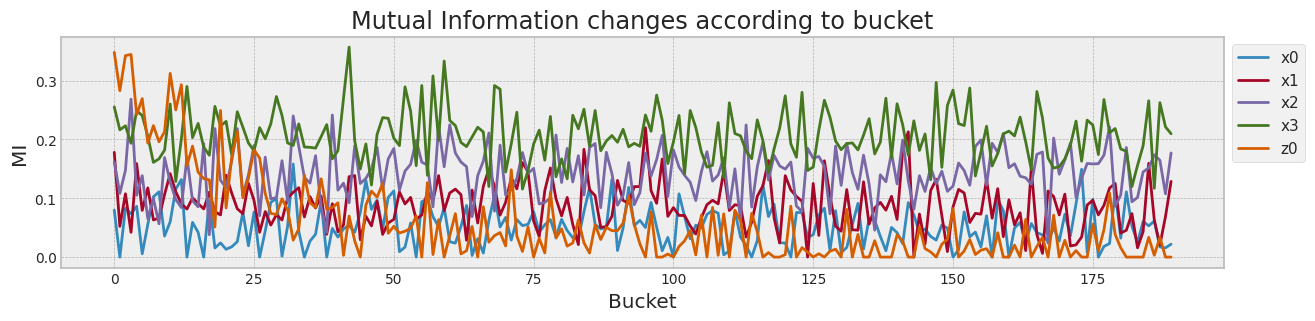

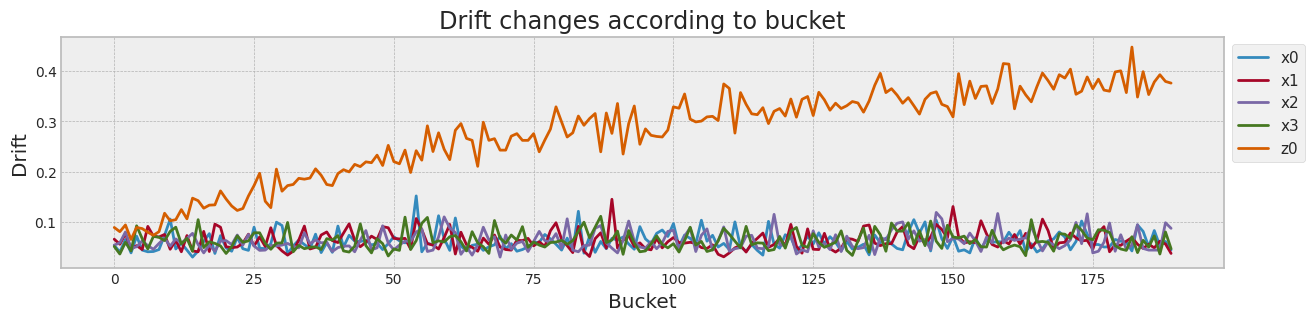

In [43]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

In [44]:
a--

SyntaxError: ignored

## 학습 및 전체 예측

+ 2000개를 학습하고, 이후 38000개를 추정한다.

cuda:0


100%|██████████| 1000/1000 [00:23<00:00, 42.63it/s]


MSE: 0.26
RMSE: 0.51


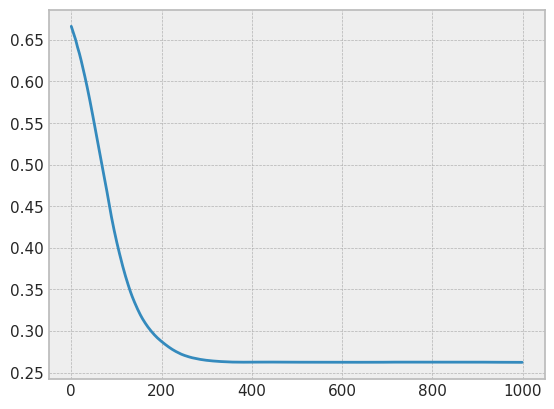

In [45]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [46]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [47]:

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8685714285714285


100%|██████████| 189/189 [00:00<00:00, 533.06it/s]


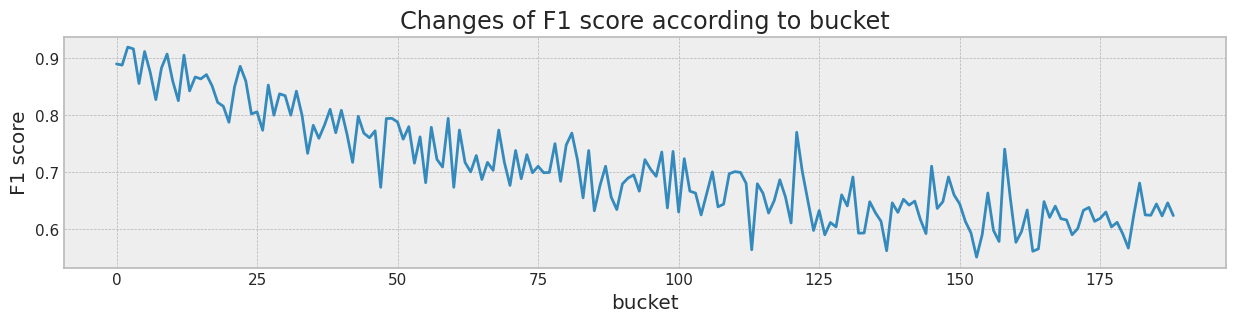

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853       0.0

In [48]:

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## 내성 학습의 적용

In [49]:

# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

lambda_f2 1.2
cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [mi loss: 0.000000] [G loss: 0.663064]
[Lambda: -0.100000] [Epoch 200/4000] [mi loss: 0.000000] [G loss: 0.629238]
[Lambda: -0.100000] [Epoch 400/4000] [mi loss: 0.000000] [G loss: 0.596062]
[Lambda: -0.100000] [Epoch 600/4000] [mi loss: 0.000000] [G loss: 0.559978]
[Lambda: -0.100000] [Epoch 800/4000] [mi loss: 0.000000] [G loss: 0.521746]
[Lambda: -0.100000] [Epoch 1000/4000] [mi loss: 0.000000] [G loss: 0.483910]
[Lambda: -0.100000] [Epoch 1200/4000] [mi loss: 0.000000] [G loss: 0.442913]
[Lambda: -0.100000] [Epoch 1400/4000] [mi loss: 0.000000] [G loss: 0.404920]
[Lambda: -0.100000] [Epoch 1600/4000] [mi loss: 0.000000] [G loss: 0.372141]
[Lambda: -0.100000] [Epoch 1800/4000] [mi loss: 0.000000] [G loss: 0.343308]
[Lambda: -0.100000] [Epoch 2000/4000] [mi loss: 0.000000] [G loss: 0.318049]
[Lambda: -0.100000] [Epoch 2200/4000] [mi loss: 0.000000] [G loss: 0.297169]
[Lambda: -0.100000] [Epoch 2400/4000] [mi loss: 0.000000] [G l

100%|██████████| 189/189 [00:00<00:00, 485.99it/s]


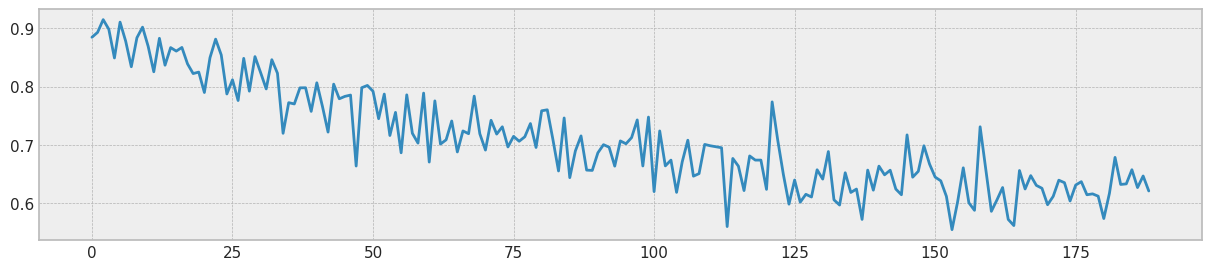

Mean F1 for all data: 0.7088965272551265
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 19.316162] [G loss: 0.511208]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 105.180084] [G loss: 0.266944]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 188.331757] [G loss: 0.227124]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 210.090500] [G loss: 0.224848]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 220.921432] [G loss: 0.223697]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 229.876511] [G loss: 0.222694]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 237.072784] [G loss: 0.221774]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 244.026840] [G loss: 0.220871]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 251.326172] [G loss: 0.220045]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 257.993988] [G loss: 0.219292]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 261.778290] [G loss: 0.218563]
[Lambda: 0.000000] [Epoch 

100%|██████████| 189/189 [00:00<00:00, 353.27it/s]


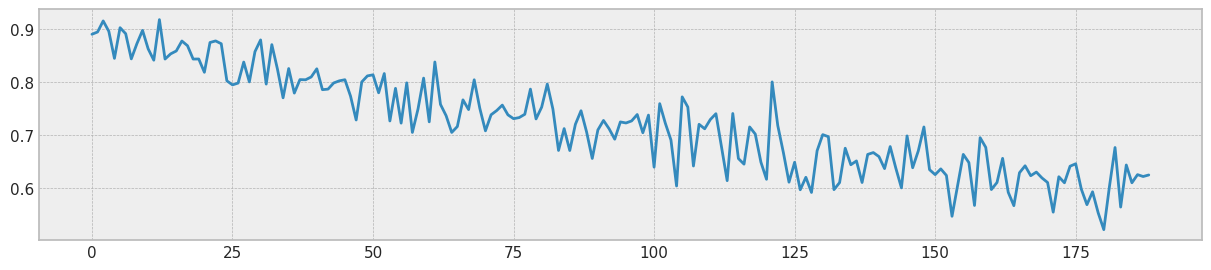

Mean F1 for all data: 0.721176812135385
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.020037] [G loss: 0.623222]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.078506] [G loss: 0.569837]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.167775] [G loss: 0.496585]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.265451] [G loss: 0.416552]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.298769] [G loss: 0.355171]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.284817] [G loss: 0.316309]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.253056] [G loss: 0.292837]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.220653] [G loss: 0.277176]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.190217] [G loss: 0.266409]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.167690] [G loss: 0.257279]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.148677] [G loss: 0.249762]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 345.20it/s]


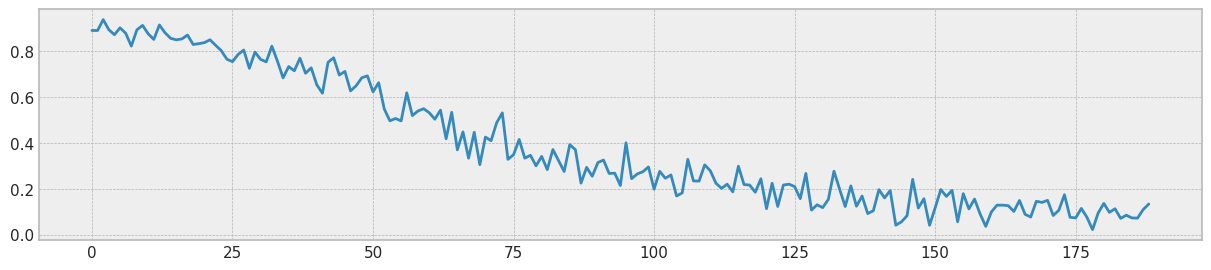

Mean F1 for all data: 0.38773448433790614
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.007139] [G loss: 0.627994]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.018357] [G loss: 0.583075]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.039199] [G loss: 0.526471]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.066431] [G loss: 0.461640]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.086831] [G loss: 0.401224]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.093520] [G loss: 0.353786]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.091924] [G loss: 0.320146]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.084111] [G loss: 0.297693]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.075252] [G loss: 0.281987]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.066586] [G loss: 0.270301]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.058860] [G loss: 0.260837]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss:

100%|██████████| 189/189 [00:00<00:00, 323.00it/s]


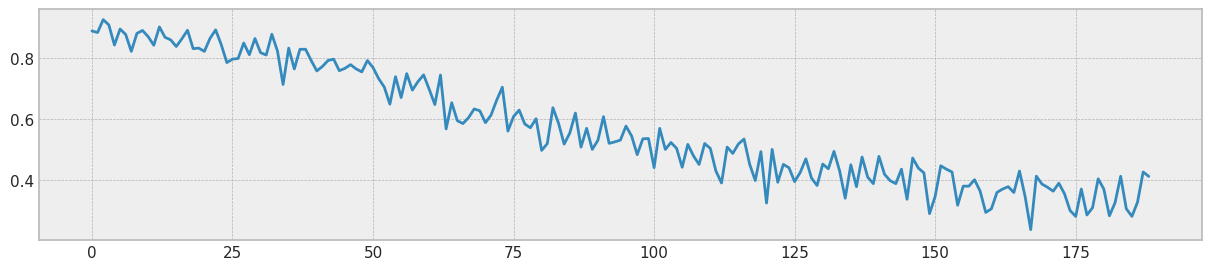

Mean F1 for all data: 0.5728063349608085
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.005376] [G loss: 0.629871]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.006886] [G loss: 0.588285]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.014519] [G loss: 0.538230]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.025471] [G loss: 0.480858]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.035334] [G loss: 0.424462]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.041426] [G loss: 0.376283]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.043034] [G loss: 0.339537]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.040916] [G loss: 0.312969]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.037128] [G loss: 0.293951]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.032860] [G loss: 0.279442]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.028636] [G loss: 0.267709]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 264.74it/s]


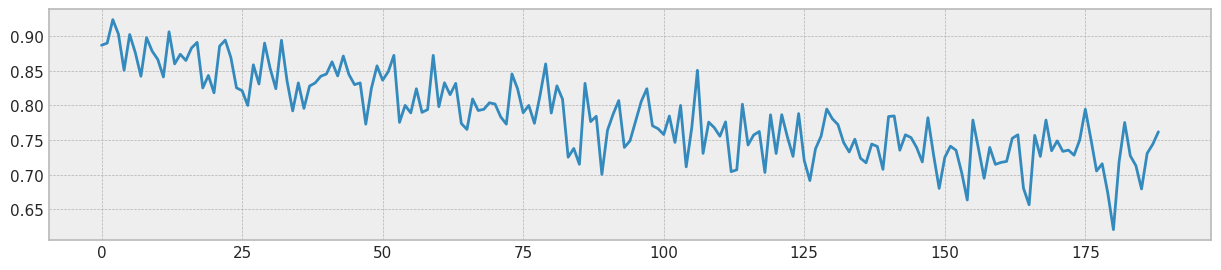

Mean F1 for all data: 0.7850010068760686
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.005101] [G loss: 0.630879]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003148] [G loss: 0.591079]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.006397] [G loss: 0.544595]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.011234] [G loss: 0.491947]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.016194] [G loss: 0.438926]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.019932] [G loss: 0.391833]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.021470] [G loss: 0.354412]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.021262] [G loss: 0.325588]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.019570] [G loss: 0.304038]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.017511] [G loss: 0.287310]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.014857] [G loss: 0.273877]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 347.70it/s]


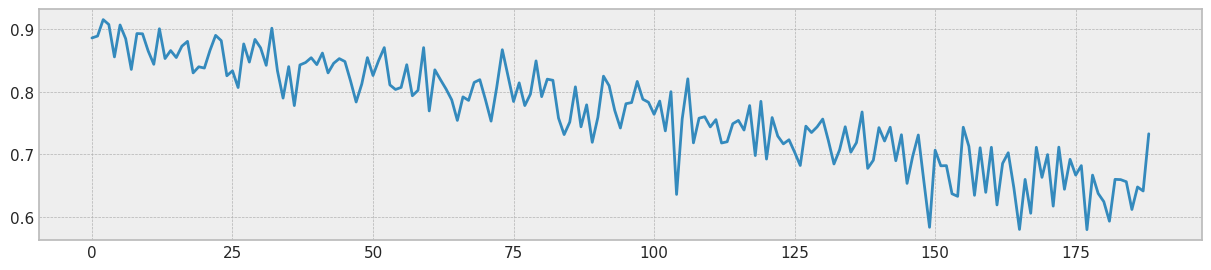

Mean F1 for all data: 0.7659473098764698
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.005159] [G loss: 0.631501]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001599] [G loss: 0.592844]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.003039] [G loss: 0.548592]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.005177] [G loss: 0.499179]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.007710] [G loss: 0.448796]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.009757] [G loss: 0.403218]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.010920] [G loss: 0.365708]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.010945] [G loss: 0.336137]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.010325] [G loss: 0.312799]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.009238] [G loss: 0.294069]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.007964] [G loss: 0.278928]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 336.80it/s]


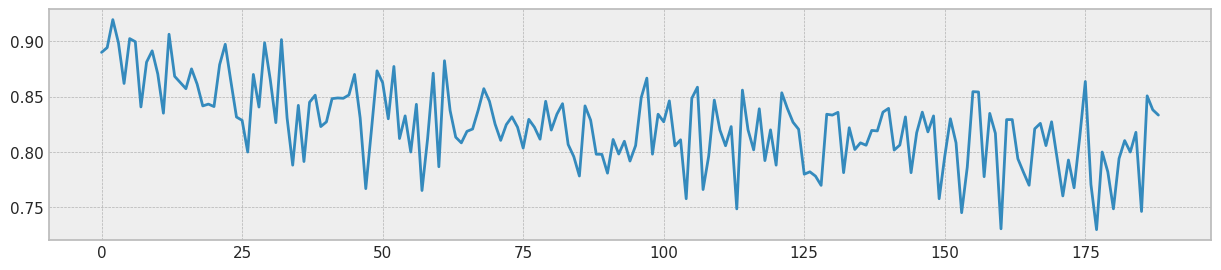

Mean F1 for all data: 0.8244244113177561
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.005296] [G loss: 0.631926]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000920] [G loss: 0.594047]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001478] [G loss: 0.551396]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.002448] [G loss: 0.504040]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.003603] [G loss: 0.455949]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.004680] [G loss: 0.411699]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.005354] [G loss: 0.374579]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.005465] [G loss: 0.344564]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.005190] [G loss: 0.320457]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.004633] [G loss: 0.300408]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.004001] [G loss: 0.284052]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 341.87it/s]


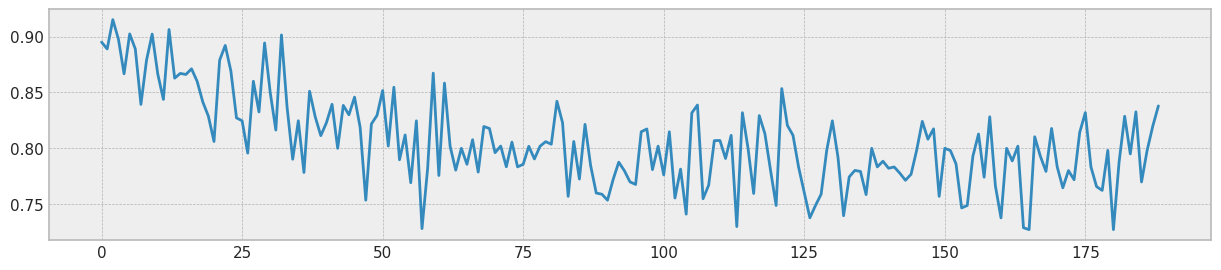

Mean F1 for all data: 0.8060833514922492
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.005442] [G loss: 0.632233]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000630] [G loss: 0.594915]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000662] [G loss: 0.553504]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.001035] [G loss: 0.507932]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001551] [G loss: 0.461480]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.002032] [G loss: 0.418524]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.002417] [G loss: 0.381711]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.002499] [G loss: 0.351338]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.002388] [G loss: 0.326485]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.002161] [G loss: 0.305532]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.001879] [G loss: 0.288337]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 328.61it/s]


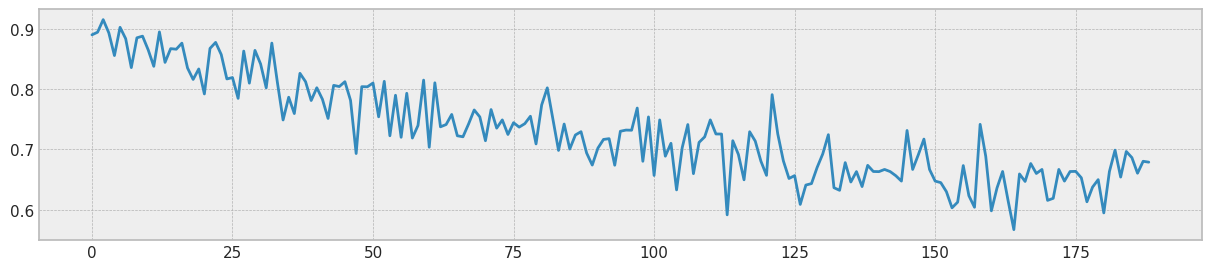

Mean F1 for all data: 0.730102436404008
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.005581] [G loss: 0.632467]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000497] [G loss: 0.595641]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000316] [G loss: 0.555041]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000401] [G loss: 0.510713]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000560] [G loss: 0.465739]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000725] [G loss: 0.424046]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000863] [G loss: 0.387982]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000912] [G loss: 0.357326]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000899] [G loss: 0.331731]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000830] [G loss: 0.309941]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000723] [G loss: 0.292065]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 346.86it/s]


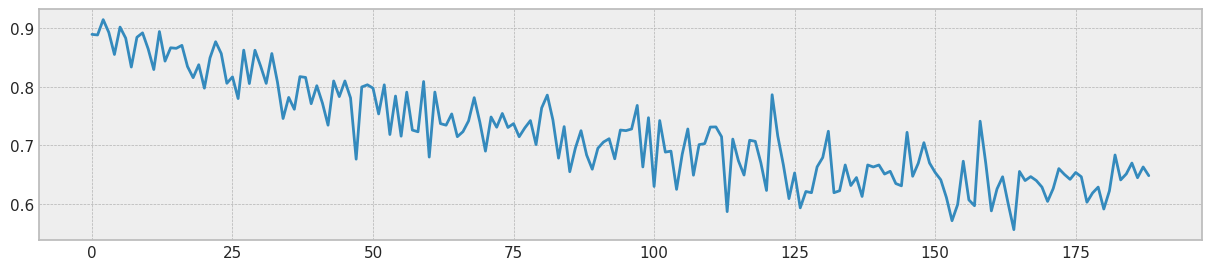

Mean F1 for all data: 0.7209201312161698
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.005705] [G loss: 0.632652]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000453] [G loss: 0.596164]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000182] [G loss: 0.556232]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000127] [G loss: 0.512988]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000144] [G loss: 0.469201]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000171] [G loss: 0.428535]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000195] [G loss: 0.393073]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000204] [G loss: 0.362482]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000197] [G loss: 0.336422]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000184] [G loss: 0.314011]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000163] [G loss: 0.295423]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 339.10it/s]


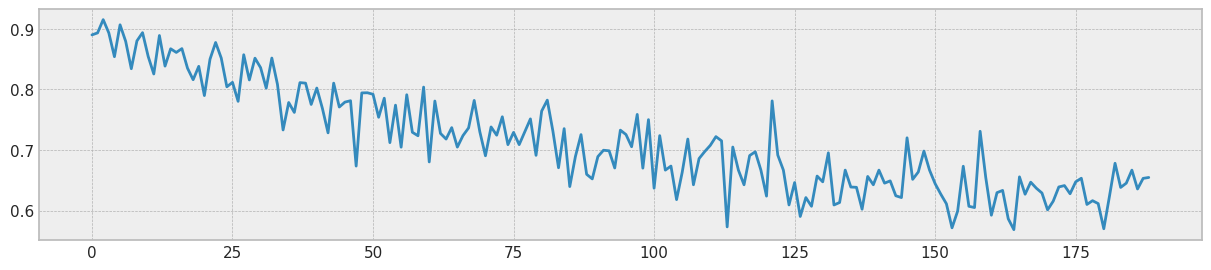

Mean F1 for all data: 0.714946437788246


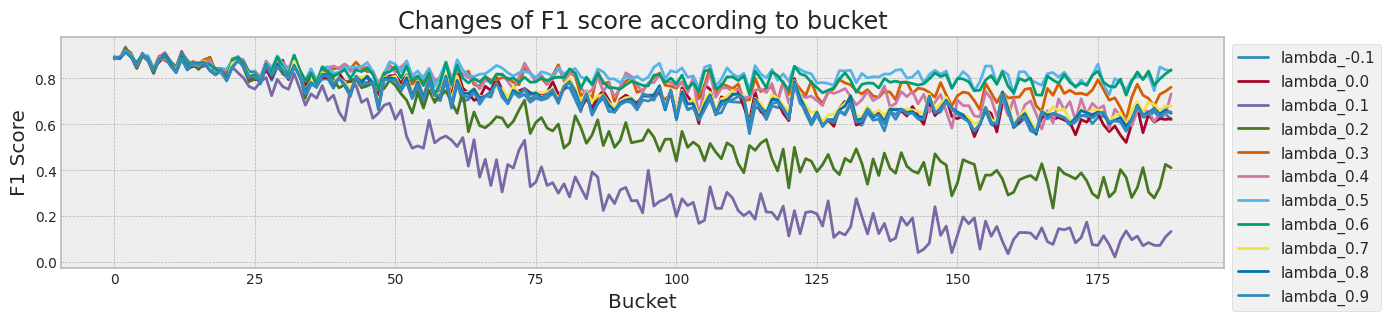

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0       Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
0   Case #1, Normal model  0.881356  0.884793  0.708897  0.620370  0.259820
1                     0.0  0.898876  0.889908  0.721177  0.624390  0.265435
2                     0.1  0.870056  0.889908  0.387734  0.133333  0.229369
3                     0.2  0.858757  0.890909  0.572806  0.410959  0.228114
4                     0.3  0.865169  0.886878  0.785001  0.761905  0.250609
5                     0.4  0.870056  0.885845  0.765947  0.732673  0.266231
6                     0.5  0.875000  0.889908  0.824424  0.833333  0.261667
7                     0.6  0.881356  0.894977  0.806083  0.837945  0.259820
8                     0.7  0.875000  0.889908  0.730102  0.678733  0.261667
9                     0.8  0.875000  0.889908  0.720920  0.648402  0.261667
10                    0.9  0.875000  0.889908  0.714946  0.654545  0.261667

In [50]:
avaible_range = 400
seed = 1
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_f_set2 = [1.2] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X[2000:][['x0','x1','x2','x3','z0','b']],y[2000:])
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
        else:
            result_table2['lambda'].append(lambda_f)
            
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

In [51]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [52]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [53]:
x1.shape

(40000, 5)

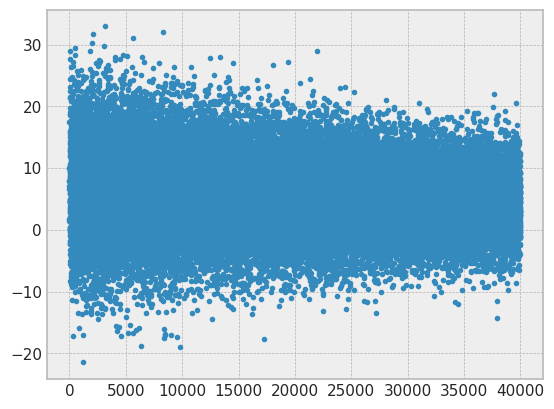

In [54]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4] 
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)
 
plt.plot(y1_array,'.')

In [55]:
y1 = [1 if y_ > 5 else 0 for y_ in y1_array]

In [56]:
sum(y1)

21325

In [57]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x1    0.018550
x3    0.008429
x2    0.006772
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 67.35it/s]


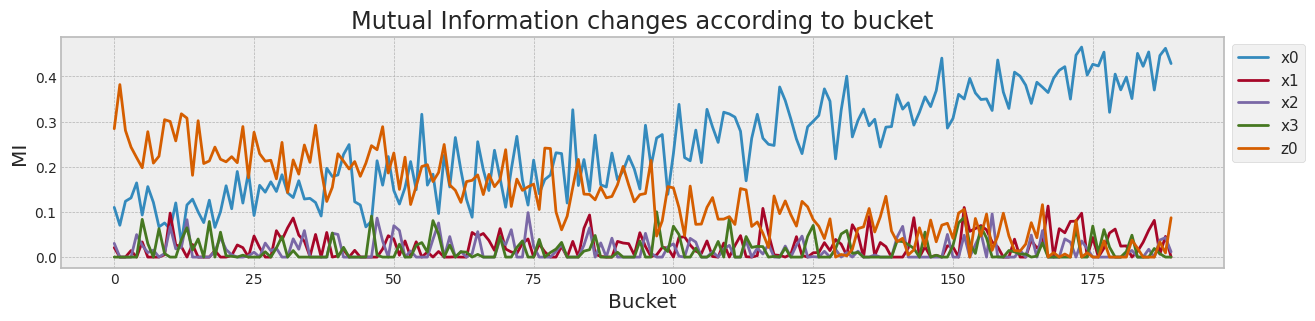

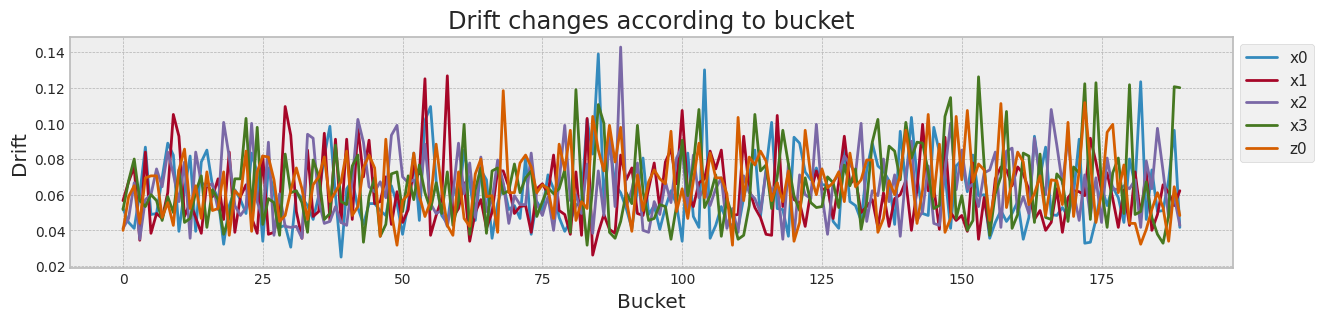

In [58]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X1[bk*bucket_size:bk*bucket_size+bucket_size], y1[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X1[0:1800].values,X1[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## 학습 및 전체 예측

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


MSE: 0.04
RMSE: 0.19


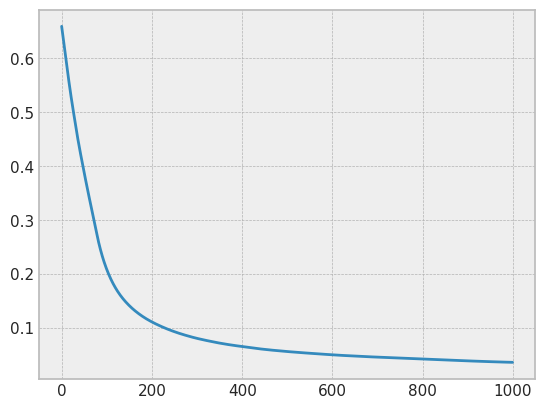

In [59]:
import copy
import torch.optim as optim
 
seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y1[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y1[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 504.53it/s]


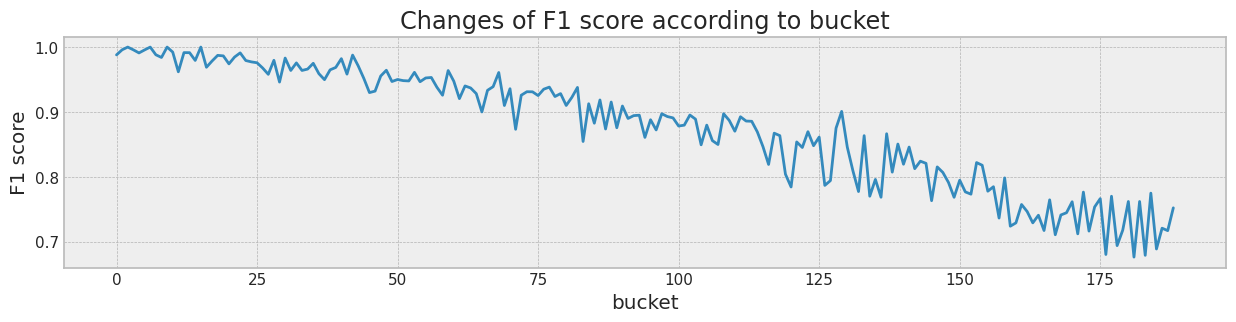

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.087066

In [60]:
XT = X1[2000:][['x0','x1','x2','x3','z0']]
yT = y1[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #2 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [61]:
X1['b'] = [int(b) for b in X1.index.values]
X1

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792 -1.925585      0
1      2.846794  0.461018  1.213784  1.282154  3.281450      1
2      2.232850  0.876278  2.307393  2.019052  0.187403      2
3     -0.198843  2.579531  0.078102  1.019118  2.385340      3
4      1.618080  1.683218  1.826908  0.697273  0.195648      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070  4.096949  39995
39996 -0.037401  1.055617  0.084065  1.252068  3.850920  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.498200  39997
39998  0.823467  1.489013 -0.191516 -0.238143  5.022454  39998
39999  2.024101  2.498025  0.198514  2.241146  0.816579  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 44.337929] [G loss: 0.479356]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 258.603058] [G loss: 0.167605]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 517.607544] [G loss: 0.078098]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 741.547424] [G loss: 0.051432]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 960.810425] [G loss: 0.037684]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 1181.940186] [G loss: 0.029118]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 1411.487183] [G loss: 0.022937]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1654.074341] [G loss: 0.018343]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1889.434204] [G loss: 0.015104]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 2127.275635] [G loss: 0.012432]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 2377.471191] [G loss: 0.010282]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 2642.408203] [

100%|██████████| 189/189 [00:00<00:00, 327.56it/s]


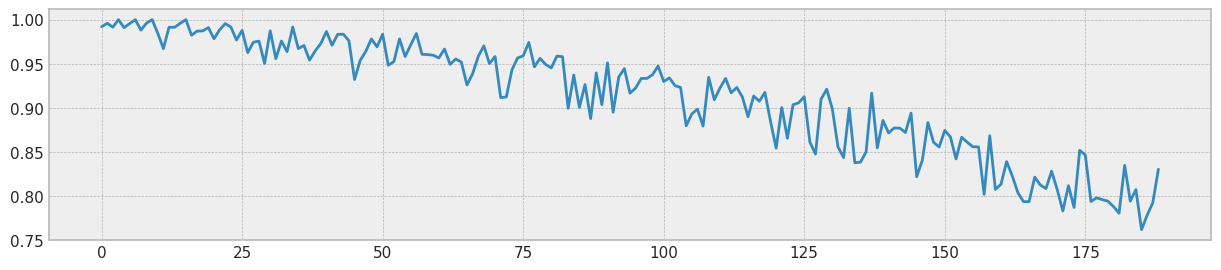

Mean F1 for all data: 0.9129560221808936
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.065951] [G loss: 0.575243]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.078144] [G loss: 0.493714]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.099995] [G loss: 0.420184]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.136796] [G loss: 0.340409]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.146494] [G loss: 0.270942]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.138476] [G loss: 0.221807]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.127138] [G loss: 0.185755]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.116526] [G loss: 0.158431]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.107120] [G loss: 0.137230]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.099970] [G loss: 0.120165]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.094113] [G loss: 0.106181]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 317.04it/s]


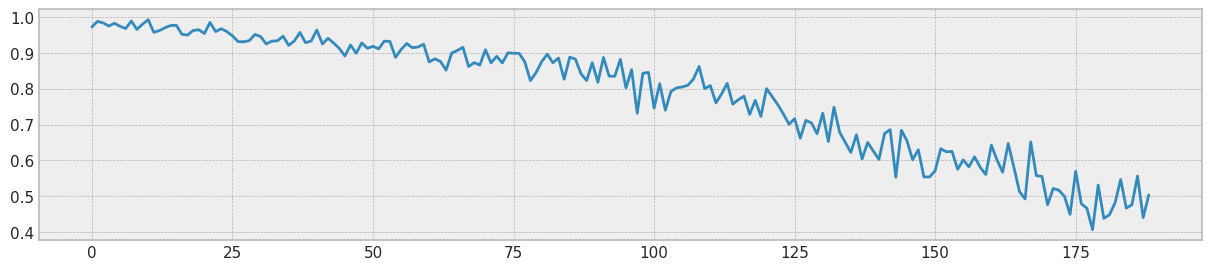

Mean F1 for all data: 0.7833643820519409
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.018489] [G loss: 0.584703]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.019629] [G loss: 0.504157]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.022988] [G loss: 0.436378]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.033968] [G loss: 0.364682]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.040136] [G loss: 0.293834]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.040487] [G loss: 0.240804]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.038645] [G loss: 0.201636]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.036420] [G loss: 0.172037]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.034431] [G loss: 0.149101]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.032889] [G loss: 0.130767]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.031853] [G loss: 0.115743]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 318.61it/s]


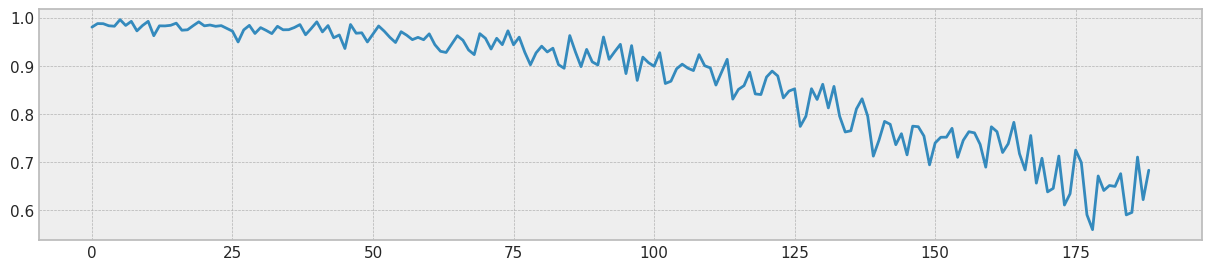

Mean F1 for all data: 0.8695814142813798
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.010342] [G loss: 0.588097]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.007837] [G loss: 0.508489]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.008714] [G loss: 0.442148]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.012524] [G loss: 0.375815]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.015766] [G loss: 0.306562]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.016355] [G loss: 0.251562]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.016089] [G loss: 0.210864]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.015498] [G loss: 0.180158]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.015158] [G loss: 0.156224]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.014811] [G loss: 0.137167]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.014553] [G loss: 0.121700]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 317.26it/s]


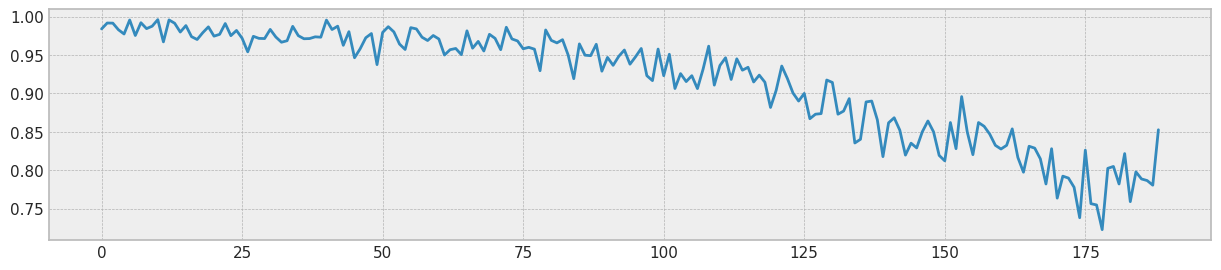

Mean F1 for all data: 0.9156953502345548
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.007799] [G loss: 0.589868]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003998] [G loss: 0.510795]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.004074] [G loss: 0.445162]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.005486] [G loss: 0.382395]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.007194] [G loss: 0.315968]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.007550] [G loss: 0.259067]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.007546] [G loss: 0.217348]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.007504] [G loss: 0.185821]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.007392] [G loss: 0.161405]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.007369] [G loss: 0.141970]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.007398] [G loss: 0.126182]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 308.61it/s]


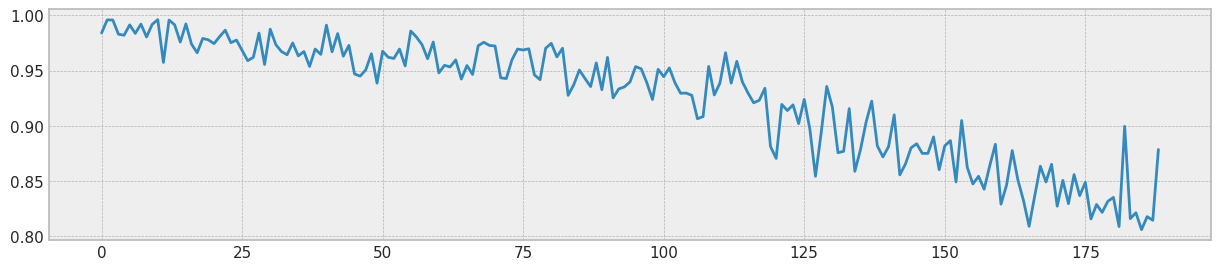

Mean F1 for all data: 0.924911304364104
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.006791] [G loss: 0.590945]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.002412] [G loss: 0.512229]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002156] [G loss: 0.447056]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.002640] [G loss: 0.386431]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.003465] [G loss: 0.323261]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.003699] [G loss: 0.264581]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.003740] [G loss: 0.221905]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.003696] [G loss: 0.189941]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.003674] [G loss: 0.165207]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.003734] [G loss: 0.145577]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.003784] [G loss: 0.129714]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 318.83it/s]


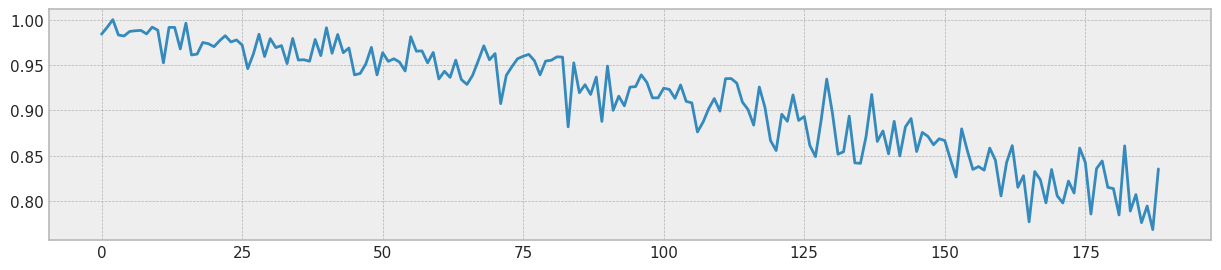

Mean F1 for all data: 0.9114407924489931
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.006339] [G loss: 0.591663]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.001672] [G loss: 0.513202]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001261] [G loss: 0.448361]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.001353] [G loss: 0.388887]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.001693] [G loss: 0.328799]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.001831] [G loss: 0.269610]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.001838] [G loss: 0.225904]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.001815] [G loss: 0.193371]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.001827] [G loss: 0.168297]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.001864] [G loss: 0.148571]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.001927] [G loss: 0.132593]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 317.19it/s]


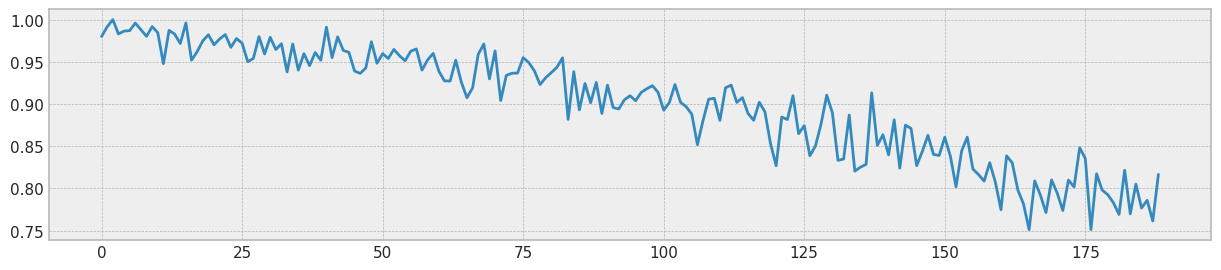

Mean F1 for all data: 0.900023537259777
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.006126] [G loss: 0.592189]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.001305] [G loss: 0.513911]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000822] [G loss: 0.449310]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000745] [G loss: 0.390311]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000821] [G loss: 0.332271]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.000864] [G loss: 0.273652]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.000854] [G loss: 0.228932]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.000837] [G loss: 0.195970]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.000845] [G loss: 0.170716]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.000878] [G loss: 0.150909]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.000910] [G loss: 0.134964]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 316.22it/s]


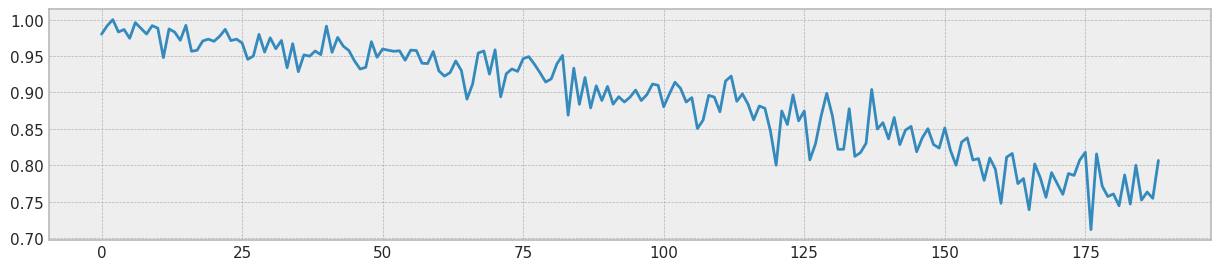

Mean F1 for all data: 0.89094844102321
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.006028] [G loss: 0.592582]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.001120] [G loss: 0.514450]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000607] [G loss: 0.450032]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000449] [G loss: 0.391394]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000406] [G loss: 0.334911]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000388] [G loss: 0.277870]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000364] [G loss: 0.231717]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000349] [G loss: 0.198266]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000350] [G loss: 0.172791]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000358] [G loss: 0.152966]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000371] [G loss: 0.137015]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.

100%|██████████| 189/189 [00:00<00:00, 321.60it/s]


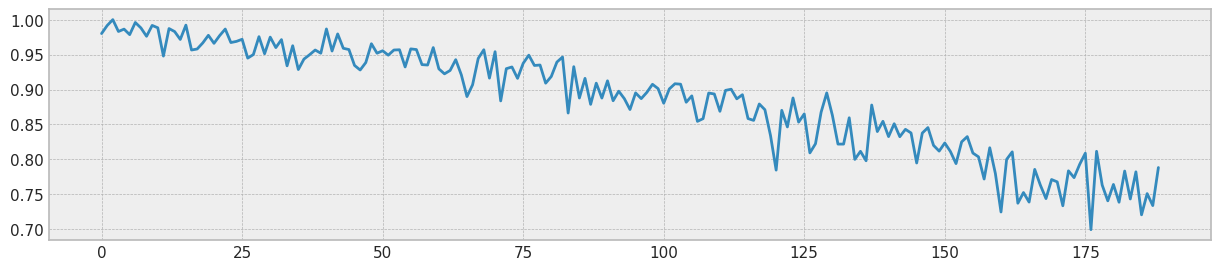

Mean F1 for all data: 0.8855025678733823
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.005988] [G loss: 0.592887]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.001032] [G loss: 0.514873]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000507] [G loss: 0.450607]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000317] [G loss: 0.392248]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000227] [G loss: 0.337018]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000180] [G loss: 0.282182]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000150] [G loss: 0.234360]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000133] [G loss: 0.200385]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000124] [G loss: 0.174716]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000119] [G loss: 0.154858]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000118] [G loss: 0.138943]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 315.86it/s]


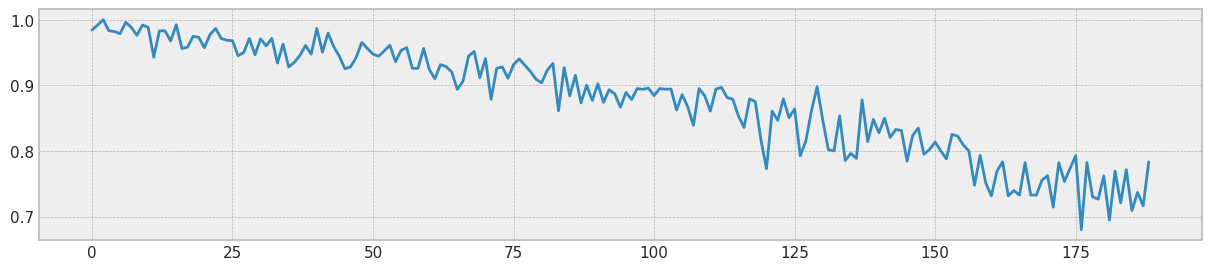

Mean F1 for all data: 0.878191295430785


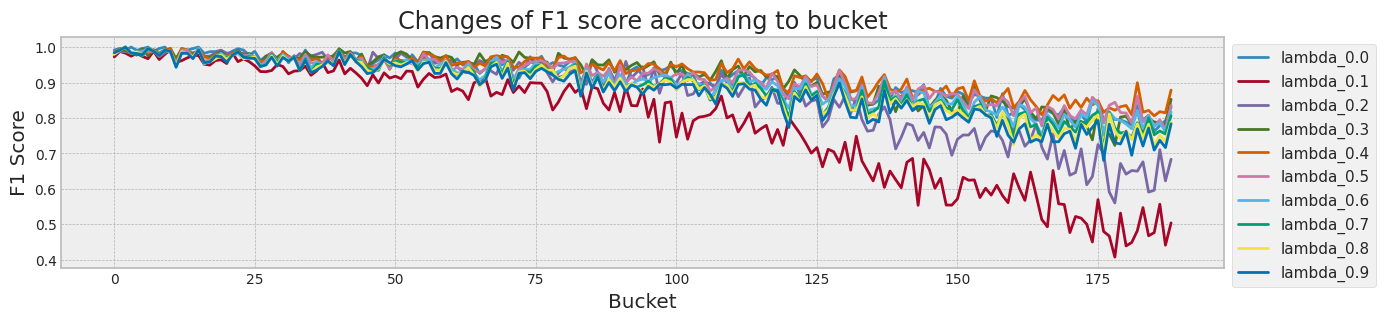

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.087066
0                0.0  0.986667  0.991935  0.912956  0.830357  0.296459
1                0.1  0.969957  0.972112  0.783364  0.503597  0.307413
2                0.2  0.973913  0.980080  0.869581  0.683230  0.292253
3                0.3  0.973913  0.984000  0.915695  0.852632  0.292253
4                0.4  0.978166  0.984000  0.924911  0.878505  0.304856
5                0.5  0.973913  0.984000  0.911441  0.835443  0.293090
6                0.6  0.969697  0.980080  0.900024  0.816667  0.280002
7                0.7  0.969697  0.980080  0.890948  0.806584  0.280002
8                0.8  0.969697  0.980080  0.885503  0.788382  0.280002
9                0.9  0.969697  0.984000  0.878191  0.783333  0.280002

In [62]:
seed_everything()

train_result = []

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.2] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X1[2000:][['x0','x1','x2','x3','z0','b']],y1[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #3 MI의 고정, Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

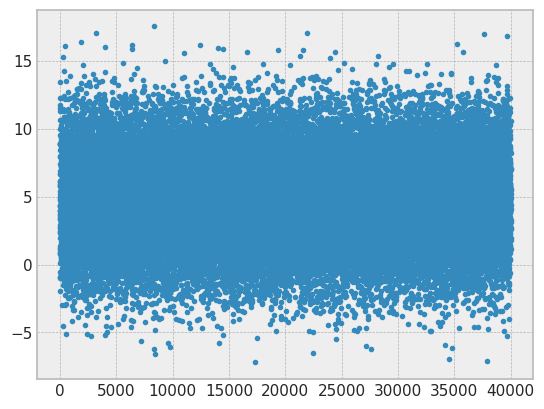

In [63]:
import matplotlib.pyplot as plt

seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = [] 
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x1[ii]))
 
plt.plot(y2_array,'.')

In [64]:
y2 = [1 if y_ > 5 else 0 for y_ in y2_array]

In [65]:
sum(y2)

19015

In [66]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

x0    0.199733
x1    0.070473
x2    0.020851
x3    0.014964
z0    0.006106
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 200/200 [00:03<00:00, 66.00it/s]


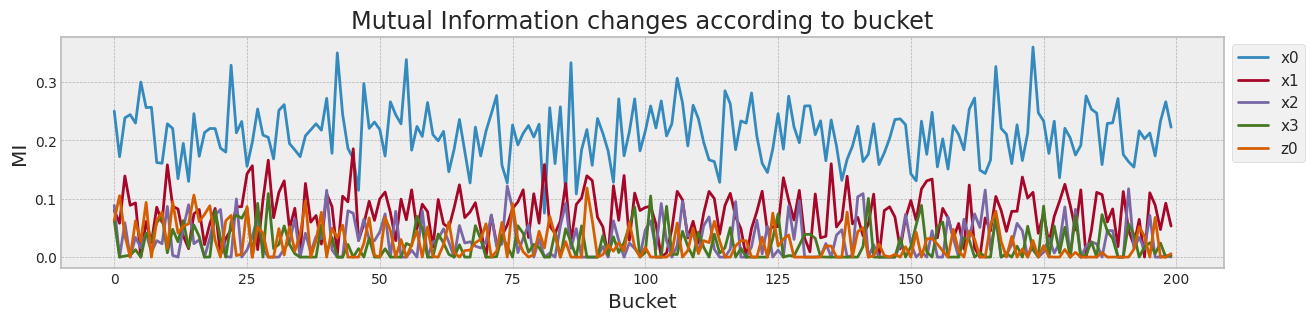

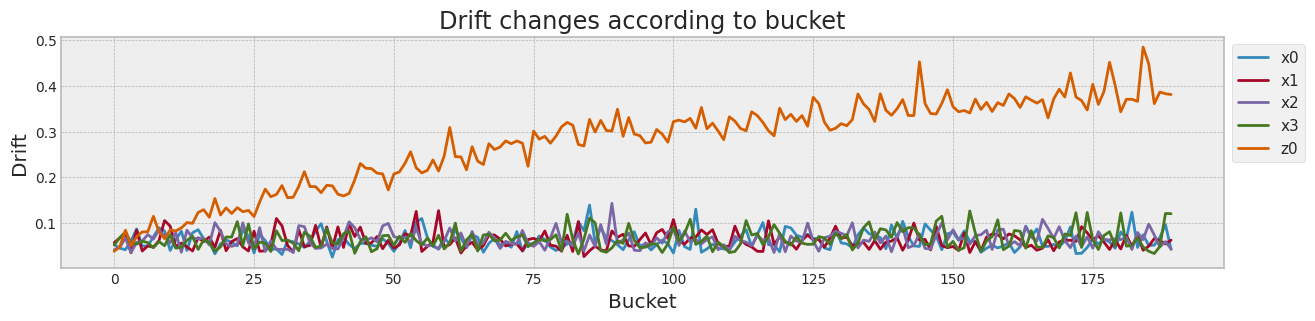

In [67]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2[bk*bucket_size:bk*bucket_size+bucket_size], y2[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X2[0:1800].values,X2[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## 학습 및 전체 예측

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 41.26it/s]


MSE: 0.09
RMSE: 0.31


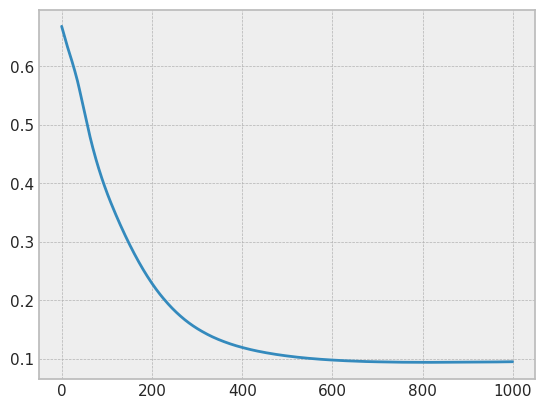

In [68]:
import copy
import torch.optim as optim
 
seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 500.09it/s]


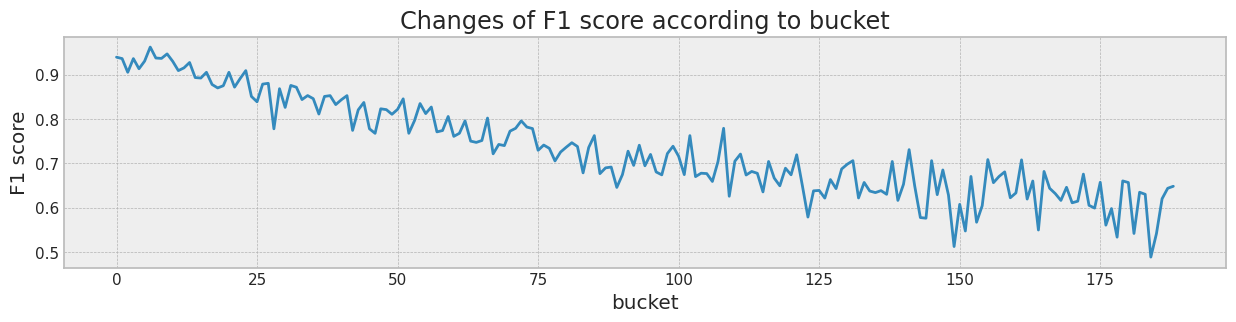

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.087066
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.005727

In [69]:
XT = X2[2000:][['x0','x1','x2','x3','z0']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #3 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## Case #3의 feature 4

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 41.24it/s]


MSE: 0.30
RMSE: 0.55


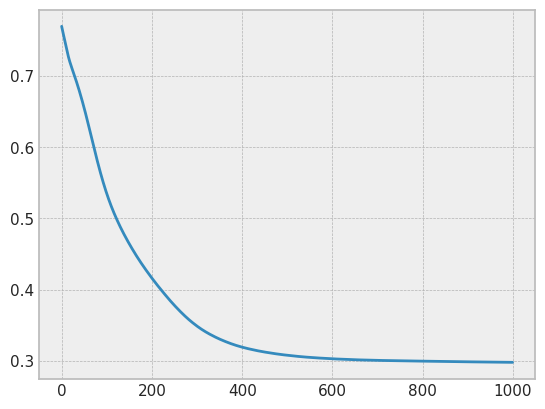

In [70]:
import copy
import torch.optim as optim
 
seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

100%|██████████| 189/189 [00:00<00:00, 486.33it/s]


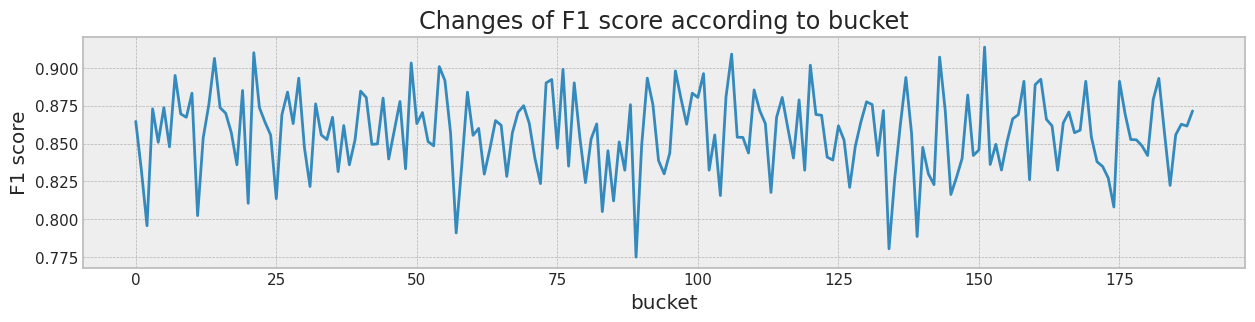

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.087066
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.005727
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.005727

In [71]:
XT = X2[2000:][['x0','x1','x2','x3']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #3 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [72]:
X2['b'] = [int(b) for b in X2.index.values]
X2

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792  0.414883      0
1      2.846794  0.461018  1.213784  1.282154  1.456334      1
2      2.232850  0.876278  2.307393  2.019052  0.837239      2
3     -0.198843  2.579531  0.078102  1.019118  1.277169      3
4      1.618080  1.683218  1.826908  0.697273  0.839361      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070 -2.562643  39995
39996 -0.037401  1.055617  0.084065  1.252068 -2.160164  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.476012  39997
39998  0.823467  1.489013 -0.191516 -0.238143  2.303669  39998
39999  2.024101  2.498025  0.198514  2.241146  0.462217  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 39.985016] [G loss: 0.514161]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 221.707062] [G loss: 0.224302]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 492.402893] [G loss: 0.120786]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 772.254089] [G loss: 0.080998]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 1013.021545] [G loss: 0.063482]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 1227.365845] [G loss: 0.053389]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 1431.723755] [G loss: 0.047059]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 1631.553589] [G loss: 0.043259]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 1820.705200] [G loss: 0.040569]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 1993.556030] [G loss: 0.038543]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 2163.654785] [G loss: 0.037128]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 2319.914795] 

100%|██████████| 189/189 [00:00<00:00, 325.63it/s]


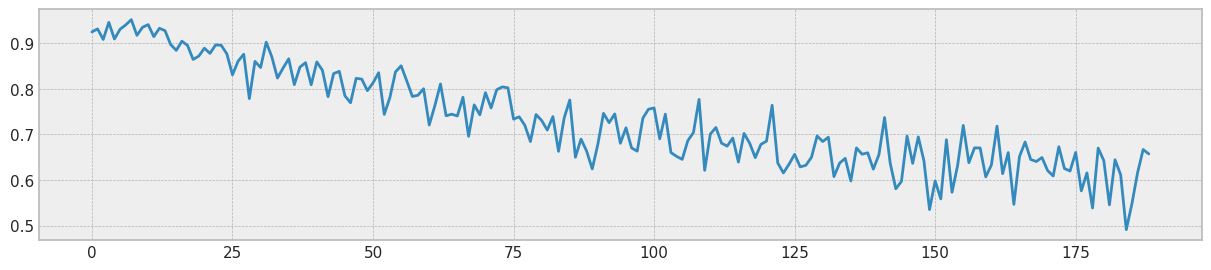

Mean F1 for all data: 0.7325707203838511
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.027311] [G loss: 0.628979]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.088878] [G loss: 0.566033]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.156974] [G loss: 0.493856]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.186313] [G loss: 0.432730]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.186892] [G loss: 0.386816]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.192164] [G loss: 0.346667]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.223526] [G loss: 0.302329]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.245491] [G loss: 0.260293]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.249261] [G loss: 0.226569]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.245329] [G loss: 0.199459]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.238208] [G loss: 0.177344]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 327.19it/s]


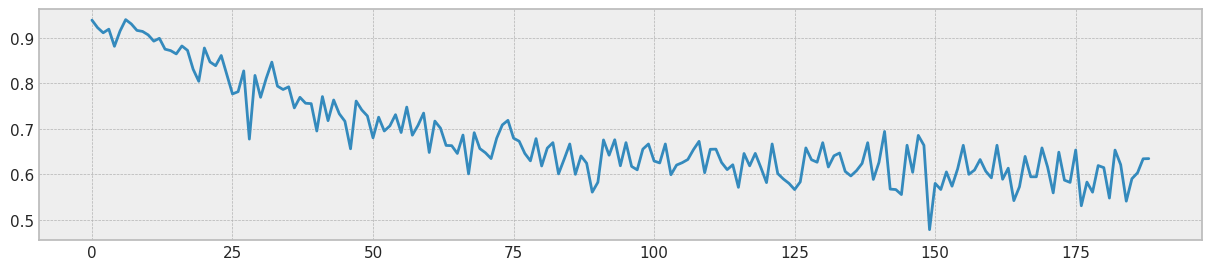

Mean F1 for all data: 0.6816085075745206
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.007531] [G loss: 0.634089]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.020116] [G loss: 0.581019]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.039297] [G loss: 0.518655]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.051730] [G loss: 0.459146]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.056176] [G loss: 0.409840]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.058266] [G loss: 0.369240]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.065306] [G loss: 0.330175]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.076050] [G loss: 0.290616]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.083040] [G loss: 0.255340]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.084951] [G loss: 0.225961]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.084217] [G loss: 0.201788]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 315.55it/s]


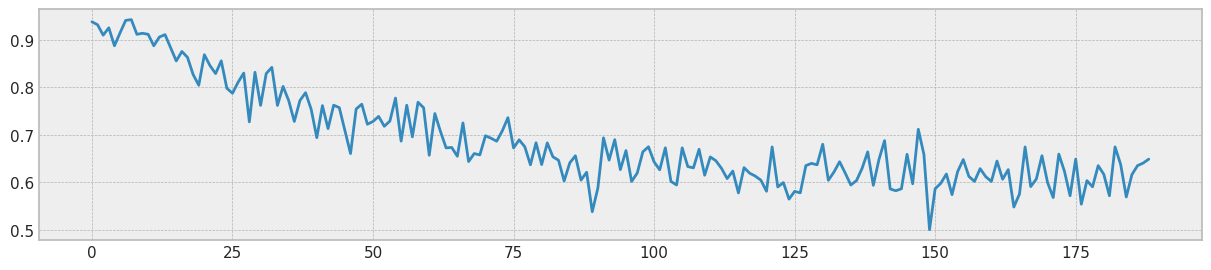

Mean F1 for all data: 0.6879255408383158
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.004502] [G loss: 0.635791]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.007242] [G loss: 0.586762]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.014635] [G loss: 0.529495]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.020535] [G loss: 0.472046]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.023199] [G loss: 0.422465]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.024126] [G loss: 0.381781]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.026288] [G loss: 0.345097]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.031530] [G loss: 0.308472]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.035535] [G loss: 0.274382]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.038153] [G loss: 0.244181]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.038726] [G loss: 0.218851]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 330.78it/s]


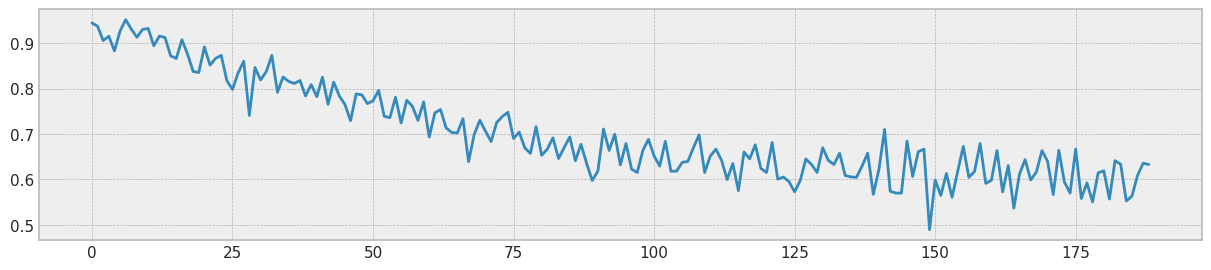

Mean F1 for all data: 0.7010812074993156
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.003691] [G loss: 0.636680]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.003238] [G loss: 0.589740]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.006336] [G loss: 0.535522]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.009205] [G loss: 0.479909]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.010754] [G loss: 0.430474]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.011388] [G loss: 0.389581]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.012335] [G loss: 0.353824]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.014506] [G loss: 0.319742]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.016943] [G loss: 0.286960]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.018560] [G loss: 0.257200]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.019258] [G loss: 0.231295]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 313.08it/s]


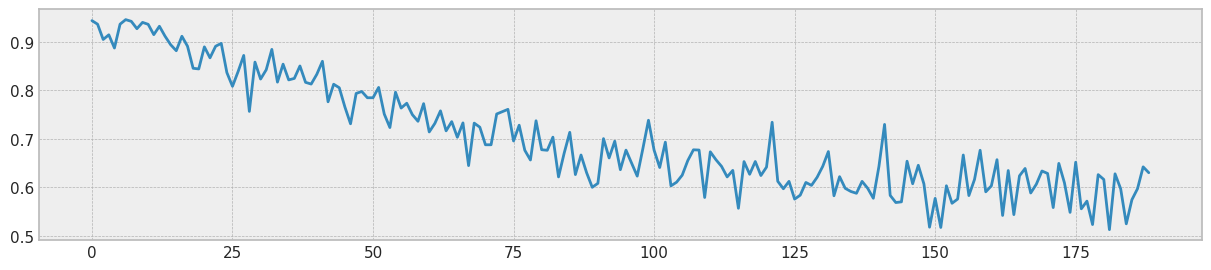

Mean F1 for all data: 0.7026332590837118
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.003430] [G loss: 0.637222]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001622] [G loss: 0.591591]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002991] [G loss: 0.539268]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.004369] [G loss: 0.485095]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.005189] [G loss: 0.436095]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.005526] [G loss: 0.395191]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.006027] [G loss: 0.359932]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.006969] [G loss: 0.327399]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.008204] [G loss: 0.296116]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.009243] [G loss: 0.266866]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.009861] [G loss: 0.240826]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 312.76it/s]


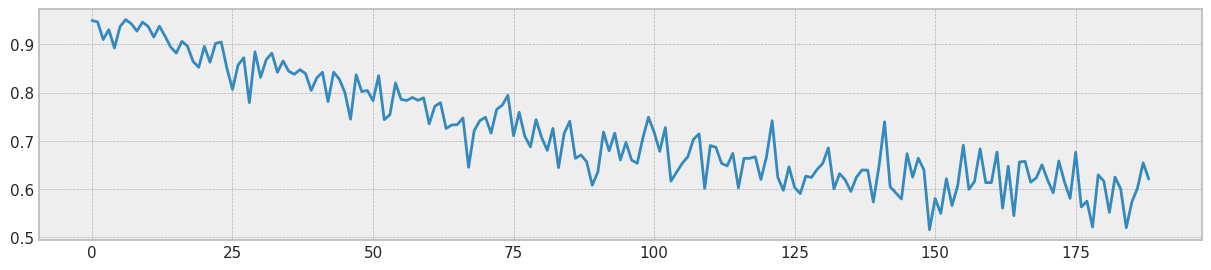

Mean F1 for all data: 0.718166075559592
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.003352] [G loss: 0.637582]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000898] [G loss: 0.592853]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.001435] [G loss: 0.541901]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.002039] [G loss: 0.488861]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.002427] [G loss: 0.440311]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.002629] [G loss: 0.399447]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.002861] [G loss: 0.364576]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.003297] [G loss: 0.333001]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.003942] [G loss: 0.302822]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.004500] [G loss: 0.274342]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.004883] [G loss: 0.248519]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 298.19it/s]


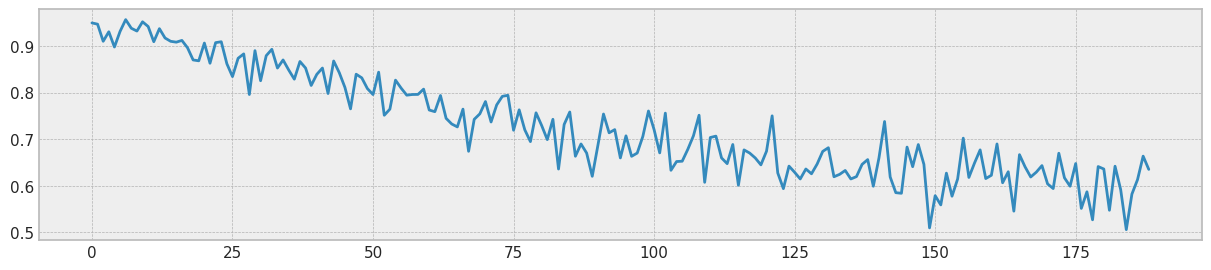

Mean F1 for all data: 0.7274206031521622
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.003346] [G loss: 0.637841]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000560] [G loss: 0.593758]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000682] [G loss: 0.543829]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000906] [G loss: 0.491638]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.001075] [G loss: 0.443463]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.001166] [G loss: 0.402746]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.001260] [G loss: 0.368183]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.001429] [G loss: 0.337352]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.001713] [G loss: 0.308226]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.002008] [G loss: 0.280457]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.002201] [G loss: 0.254940]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 317.01it/s]


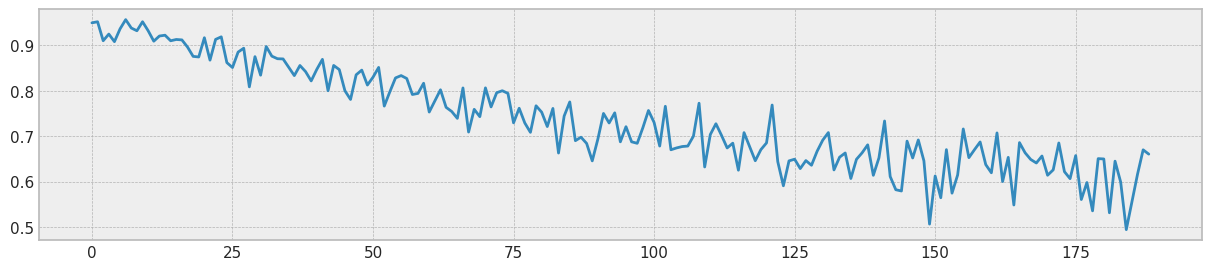

Mean F1 for all data: 0.7376648510328194
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.003368] [G loss: 0.638031]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000403] [G loss: 0.594443]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000324] [G loss: 0.545298]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000369] [G loss: 0.493751]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000416] [G loss: 0.445932]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000441] [G loss: 0.405374]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000466] [G loss: 0.371057]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000524] [G loss: 0.340710]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000616] [G loss: 0.312442]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000724] [G loss: 0.285531]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000807] [G loss: 0.260358]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 299.61it/s]


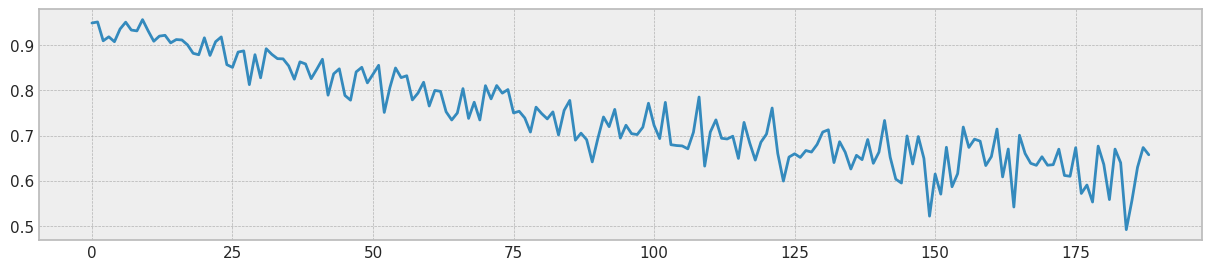

Mean F1 for all data: 0.7429497285497785
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 2.850632] [G loss: 0.689475]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.003402] [G loss: 0.638184]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000340] [G loss: 0.595001]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000175] [G loss: 0.546464]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000137] [G loss: 0.495490]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000128] [G loss: 0.447984]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000124] [G loss: 0.407554]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000123] [G loss: 0.373427]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000129] [G loss: 0.343513]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000143] [G loss: 0.315895]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000164] [G loss: 0.289717]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000182] [G loss: 0.265028]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 301.66it/s]


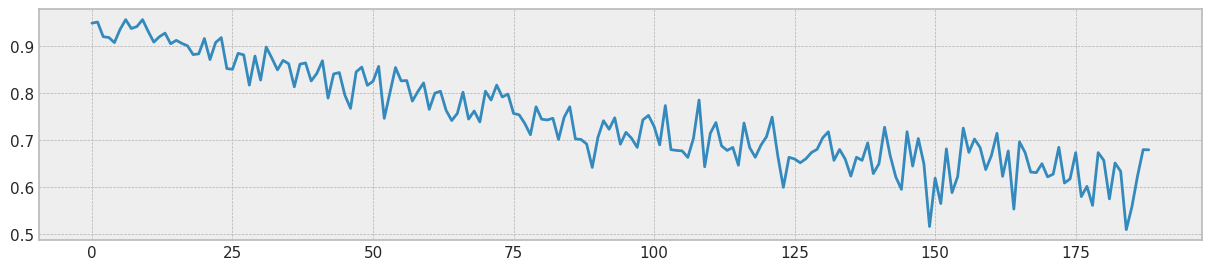

Mean F1 for all data: 0.744149331704561


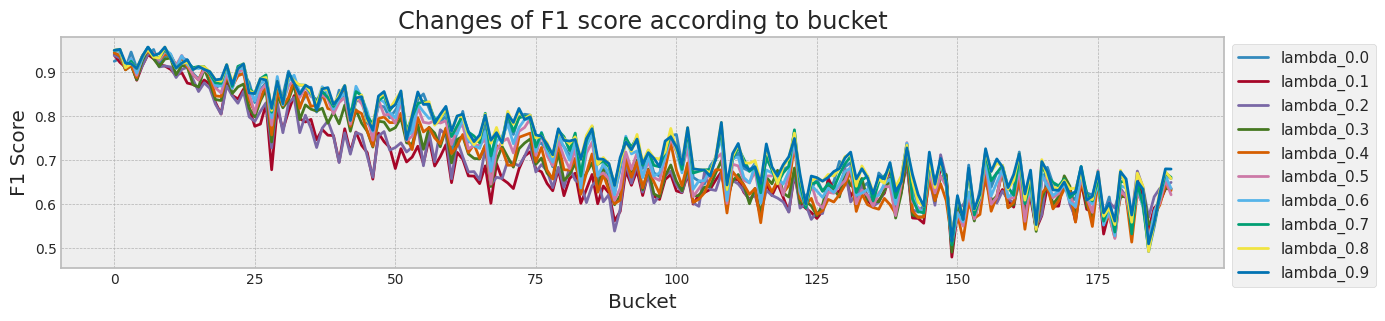

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853  0.000000
1  Case #2 Feature 5  0.875000  0.987952  0.877103  0.752137  0.087066
2  Case #3 Feature 5  0.969697  0.939394  0.731917  0.648148  0.005727
3  Case #3 Feature 4  0.969697  0.864583  0.857218  0.871560  0.005727
0                0.0  0.939024  0.924623  0.732571  0.657143  0.139956
1                0.1  0.958084  0.938776  0.681609  0.634538  0.116553
2                0.2  0.946108  0.938144  0.687926  0.648649  0.114162
3                0.3  0.952381  0.944162  0.701081  0.632911  0.103701
4                0.4  0.952381  0.944162  0.702633  0.630137  0.108794
5                0.5  0.958084  0.949495  0.718166  0.620370  0.105645
6                0.6  0.951807  0.949495  0.727421  0.635071  0.099694
7                0.7  0.946108  0.949495  0.737665  0.660377  0.102946
8                0.8  0.946108  0.949495  0.742950  0.657277  0.102946
9                0.9  0.946108  0.949495  0.744149  0.679070  0.102946

In [73]:

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.2] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X2[2000:][['x0','x1','x2','x3','z0','b']],y2[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(y^,z) 을 최소화 한다.

In [ ]:
H=40
minibatch = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

In [ ]:

def test_model2(generator_, tX, ty, s1):
    generator_.eval()


    y_hat = generator_(tX)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [ ]:

def test_all_data2(generator,XT,yT):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            #xs = adapter1(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(tmp_x[:,0:5])
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train[:,0:5]).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = s1_train[s].reshape(-1,1) #torch.clone(s1_train[s].reshape(-1,1)) #Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        y2_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y2_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    


        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret2(y의 샘플)는 maximize 하야 하고
        # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret1 + torch.abs(ret2)

        mi_losses.append(-ret2)

        optimizer_G.zero_grad()
        optimizer_M.zero_grad()

        loss = (1-lambda_f) * g_loss +  lambda_f * mi_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model2(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [ ]:
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

#lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:

    f1,mi,last_generator = train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

In [ ]:
result4_df[['test_f1','init_f1','mean_f1','last_f1','MI(y^,z)']].plot.bar(rot=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## b를 대입하여 b가 작을때는 I(y^,z)을 최대화, b가 커질수록I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(G(x,b=0),z) 을 최대화, I(G(x,b=1),z) 을 최소화 한다.

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        #Sample을 앞 뒤 반으로 나눈다.
        sa = np.random.choice(range(0,int(XS_train.shape[0]/2)),minibatch)
        sb = np.random.choice(range(int(XS_train.shape[0]/2),XS_train.shape[0]),minibatch)
        
        x_sample = s1_train[sa].reshape(-1,1) 
        y_sample = gen_y[sa] # y_train[s].reshape(-1,1) #gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(sa)] #y_train[np.random.permutation(s)].reshape(-1,1) # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        
        x2_sample = s1_train[sb].reshape(-1,1) 
        y2_sample = gen_y[sb]
        y2_shuffle = gen_y[np.random.permutation(sb)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x2_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x2_sample, y2_shuffle))))

        # ret1(bucket 앞부분의 Sample에 대한 MI)는 maximize 하야 하고
        # ret2(bucket 뒷부분의 Sample에 대한 MI)는 0으로 minimize 해야 한다.!!! => 즉, bucket의 증가, 시간이 지난수록 MI를 낮추는 방향으로 학습을 진행 하는 것!
        mi_loss = - ret1 + torch.abs(ret2)
        mi_losses1.append(-ret1)
        mi_losses2.append(-ret2)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss 

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss1: %f] [mi loss2: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses1[-1], mi_losses2[-1], a_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

In [ ]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

In [ ]:
result4_df[['test_f1','init_f1','mean_f1','last_f1','MI(y^,z)']].plot.bar(rot=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

# Case #4 (Case #1,2,3의 상황이 각 feature에 혼재되어 있는 경우)

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = np.random.normal(1,cor_,data_size)

y_array = []
cor_const = cor[4] 
cor_const2 = 3/x.shape[0]
for ii in range(x.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 고정, Drift의 증가 - x3
    e1 = np.random.normal(0.0, cor_const2 * ii)
    x[ii,3] = x[ii,3] + e1
    y_array.append(np.sum(cor * x[ii])+e)

y = [1 if y_ > 5 else 0 for y_ in y1_array]

#Case #1 MI의 감소, Drift의 증가 - x2
for i in range(400):
    s = i*100
    x[s:s+100,2] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

In [ ]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

In [ ]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)
    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

In [ ]:
# Case #2, MI의 증감(상대적), Drift의 고정 - z0
df_mis['z0'].plot(figsize=(15,3),title='MI(z0,y) changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['z0'].plot(figsize=(15,3),title='z0 Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
# Case #3 MI의 고정, Drift의 증가 - x3
df_mis['x3'].plot(figsize=(15,3),title='MI(x3,y) changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['x3'].plot(figsize=(15,3),title='x3 Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
#Case #1 MI의 감소, Drift의 증가 - x2
df_mis['x2'].plot(figsize=(15,3),title='MI(x2,y) changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['x2'].plot(figsize=(15,3),title='x2 Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Case #4의 학습

In [ ]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

In [ ]:
XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #4 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['x2'])

pd.DataFrame(result_table3)

In [ ]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 4, test_f1',f1)

In [ ]:
XT = X[2000:][['x0','x1','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Case #4 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['x2'])

pd.DataFrame(result_table3)

## 내성학습의 적용!

In [ ]:
X['b'] = [int(b) for b in X.index.values]
X

In [ ]:

def train_model4(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        #Sample을 앞 뒤 반으로 나눈다.
        sa = np.random.choice(range(0,int(XS_train.shape[0]/2)),minibatch)
        sb = np.random.choice(range(int(XS_train.shape[0]/2),XS_train.shape[0]),minibatch)
        
        # Case #3에 해당하는, MI변화 없이, Drift만 변하는 feature는 x3 이다.
        x_sample = Variable(torch.clone(XS_train[sa,2].detach().reshape(-1,1)) , requires_grad = True).to(device)
        y_sample = gen_y[sa] # y_train[s].reshape(-1,1) #gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(sa)] #y_train[np.random.permutation(s)].reshape(-1,1) # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        
        x2_sample = Variable(torch.clone(XS_train[sb,2].detach().reshape(-1,1)) , requires_grad = True).to(device)
        y2_sample = gen_y[sb]
        y2_shuffle = gen_y[np.random.permutation(sb)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x2_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x2_sample, y2_shuffle))))

        # ret1(bucket 앞부분의 Sample에 대한 MI)는 maximize 하야 하고
        # ret2(bucket 뒷부분의 Sample에 대한 MI)는 0으로 minimize 해야 한다.!!! => 즉, bucket의 증가, 시간이 지난수록 MI를 낮추는 방향으로 학습을 진행 하는 것!
        mi_loss = - ret1 + torch.abs(ret2)
        mi_losses1.append(-ret1)
        mi_losses2.append(-ret2)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss * alpha

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss1: %f] [mi loss2: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses1[-1], mi_losses2[-1], a_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

In [ ]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [0.07] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model4(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X[2000:][['x0','x1','x2','x3','z0','b']], y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

In [ ]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.2] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X[2000:][['x0','x1','x2','x3','z0','b']], y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])

# real-world data(Loan data)의 실험

In [ ]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

## Data load 

In [ ]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

## Data 정제

In [ ]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
     
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

In [ ]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

## Dataset 만들기

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:

X[2010].shape

In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

## Data의 MI, Drift 특성 파악
+ MI Top 5에 대하여 MI의 변화
+ MI Top 5에 대하여 Drift의 변화

In [ ]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

In [ ]:
list(COLUMNS) not in top_columns_index

In [ ]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2_df = pd.DataFrame(X2,columns = COLUMNS)
X2_df_t5 = X2_df[top_columns]

In [ ]:
from tqdm import tqdm

bucket_size_array=[5000]#[10,50,100,200]
tl = X[2010].shape[0]

for bucket_size in bucket_size_array:

    MIS = {}
    DRF = {}
    for col in top_columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((X2.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2_df_t5[bk*bucket_size:bk*bucket_size+bucket_size], 
                                   Y2[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X_df[top_columns].values,X2_df_t5[bk*bucket_size+tl:bk*bucket_size+bucket_size+tl].values)
        for ix,col in enumerate(top_columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Loan data의 학습

In [ ]:
import copy
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tl,fl = X[2010].shape

loan_scaler = MinMaxScaler()
LX = loan_scaler.fit_transform(X[2010][:,top_columns_index])

X_train = torch.tensor(LX[0:int(tl*0.9)], dtype=torch.float32).to(device)
y_train = torch.tensor(Y[2010][0:int(tl*0.9)], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(LX[int(tl*0.9):tl], dtype=torch.float32).to(device)
y_test = torch.tensor(Y[2010][int(tl*0.9):tl], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
loan_model = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)


# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(loan_model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = -np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    loan_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = loan_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    loan_model.eval()
    y_pred = loan_model(X_test)
    y_pred = (y_pred.cpu().data.numpy()> 0.5).astype(float)
    f1 = f1_score(y_pred, y_test.cpu().data.numpy())
    f1 = float(f1)
    history.append(f1)
    if f1 > best_mse:
        best_mse = f1
        best_weights = copy.deepcopy(loan_model.state_dict())
 
# restore model and return best accuracy
loan_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
bucket_size_array=[3000]

for bucket_size in bucket_size_array:
    bucket_count = int(X2.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(loan_scaler.transform(X2[bk*bucket_size:bk*bucket_size+bucket_size][:,top_columns_index]), dtype=torch.float32).to(device)
        predicted_y = loan_model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y2[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Loan data, Feature 81')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(0.0)

pd.DataFrame(result_table3)

## Concept-drift tolerant model 적용.

+ 100개씩 한 bucket으로 만든다.

In [ ]:
df_accepted['b'] = (np.asarray(list(df_accepted.index))/100).astype(int)

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:
# bucket b의 확인!
X[2010][:,81]

In [ ]:
sum(X[2010][:,81]==57)

In [ ]:
X[2010][0,81] = 58
X[2010][1,81] = 58
X[2010][2,81] = 58

In [ ]:
sum(X[2010][:,81]==57)

In [ ]:
sum(X[2010][:,81]==58)

In [ ]:
sum(X[2010][:,81]==172)

In [ ]:
X[2010].shape

In [ ]:
X[2010][103:].shape

In [ ]:
X_df_t5 = pd.DataFrame(X[2010],columns=list(COLUMNS) + ['b'])[top_columns]

+ 학습셋 X[2010]에서, MI와 Drift의 변화

In [ ]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]
#bucket 58의 개수
tl = sum(X[2010][:,81]==58)

for bucket_size in bucket_size_array:

    MIS = {}
    DRF = {}
    for col in top_columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int(X[2010][tl:].shape[0]/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X_df_t5[bk*bucket_size:bk*bucket_size+bucket_size], 
                                   Y[2010][bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X_df_t5[0:103].values,X_df_t5[bk*bucket_size+tl:bk*bucket_size+bucket_size+tl].values)
        for ix,col in enumerate(top_columns):
            MIS[col].append(mi_scores[col]) 
            DRF[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()    
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

+ 상태를 보니.... 좋은 결과가 안나올 듯... 싶은데...

### Concept-drift tolerant model 적용

<pre>
x0 --------------------------------------> |                        |
x1 --------------------------------------> |                        |
x2 --------------------------------------> |                        | 
x3 --------------------------------------> |                        |
x4 --------------------------------------> | Discriminator (D(x,g)) |
                    ...                    | predictive model       | -> y^
xi+1----->|                     |- x'i+1-> |                        |
xi+2----->|  Generator G(xi,b)  |- x'i+2-> |                        |
xi+3----->|  (Adaptive model)   |- x'i+3-> |                        | 
xi+4----->|                     |- x'i+4-> |                        |
xi+5----->|                     |- z'i+5-> |                        |
                     ^
                     |
                     b
</pre>

+ 위와 같이, MI Top5의 feature에 대하여 G를 적용하고, 나머지 feature는 그대로 Classification model에 들어가게 한다.

In [ ]:
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
#X2 = np.concatenate((X[2011],X[2012],X[2013]))
#Y2 = np.concatenate((Y[2011],Y[2012],Y[2013]))
max_b = np.max(X2[:,81])
max_b

In [ ]:

def train_model5(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]

    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    fl = 81
    generator = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net().to(device)
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        # MI 높은 top 5의 column에 대해서 b에 대한 전처리 처리를 한다.
        if lambda_f > 0.0:
            xs = adapter(XS_train[:,top_columns_index],XS_train[:,81].reshape(-1,1)/max_b) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,top_columns_index]))
        else:
            xs = XS_train[:,top_columns_index]
            a_loss = 0

        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f > 0.0:
            loss = (1-lambda_f) * g_loss + lambda_f * a_loss * alpha
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )

    
    generator.eval()

    if lambda_f > 0.0:
        adapter.eval()
        ax = adapter(XS_test[:,top_columns_index],XS_test[:,81].reshape(-1,1)/max_b)
        #XS_test[:,top_columns_index] = ax
    else:
        ax = XS_test[:,top_columns_index]
        adapter = None
        
    y_hat = generator(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',y_test.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(y_test.cpu().data.numpy(),y_hat)

    mi = 0.0
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))

    return f1,mi,generator,adapter

In [ ]:

def test_all_loan_data(generator,adapter,XT,yT):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print('XT.shape',XT.shape)
    bucket_size_array=[3000]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size], dtype=torch.float32).to(device)
            if adapter == None:
                xs = tmp_x[:,top_columns_index]
            else:
                xs = adapter(tmp_x[:,top_columns_index],tmp_x[:,81].reshape(-1,1)/max_b)
            #tmp_x[:,top_columns_index] = xs
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [ ]:
# 2010의 마지막 bucket의 개수가 94개... 157

loan_scaler = MinMaxScaler()
LX = loan_scaler.fit_transform(X[2010][:,0:81])
LX = np.concatenate((LX,X[2010][:,81].reshape(-1,1)),axis=1)

train_tensors = Namespace(XS_train = torch.tensor(LX[0:LX.shape[0] - 94], dtype=torch.float32),
                          y_train = torch.tensor(Y[2010][0:LX.shape[0] - 94], dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(LX[LX.shape[0] - 94:LX.shape[0]], dtype=torch.float32),
                         y_test = torch.tensor(Y[2010][LX.shape[0] - 94:LX.shape[0]], dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=200, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

# -0.1 은 기준 모델의 학습을 위한것.
lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] #[0.391] 

for lambda_f2 in lambda_f_set2:
    
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model5(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        TX = np.concatenate((loan_scaler.transform(X2[:,0:81]),X2[:,81].reshape(-1,1)),axis=1)
        result_table[f'lambda_{lambda_f}'] = test_all_loan_data(last_generator,last_adapter, TX , Y2)

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])